In [ ]:
!pip install python-binance 
!pip install pandas 
!pip install matplotlib 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 288 kB 10.4 MB/s 
     |████████████████████████████████| 112 kB 50.1 MB/s 
     |████████████████████████████████| 749 kB 47.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')
import numpy as np
#%matplotlib inline
client = Client()

In [ ]:
#HISTORICO 
candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1MINUTE, limit = 100)

In [ ]:
len(candles)

100

In [ ]:

price_df = pd.DataFrame(candles, columns=['dateTime',
                                          'open',
                                          'high', 'low',
                                          'close', 'volume',
                                          'closeTime', 
                                          'quoteAssetVolume',
                                          'numberOfTrades', 
                                          'takerBuyBaseVol', 
                                          'takerBuyQuoteVol', 'ignore'])
price_df.dateTime = pd.to_datetime(price_df.dateTime, unit='ms')
price_df.set_index('dateTime')
price_df.closeTime = pd.to_datetime(price_df.closeTime, unit='ms')
price_df.close = pd.to_numeric(price_df.close)
price_df.volume = pd.to_numeric(price_df.volume) 




In [ ]:
#price_df.set_index('closeTime', inplace=True)
#closeprice = price_df['close'].to_numpy()

price_df['ma50'] = price_df.close.ewm(span=50).mean()

price_df['ma21'] = price_df.close.ewm(span=21).mean()

price_df.ma50 = pd.to_numeric(price_df.ma50)

price_df.ma21 = pd.to_numeric(price_df.ma21)

price_df.ma50

0     21457.010000
1     21455.347400
2     21453.756702
3     21450.755559
4     21450.077295
          ...     
95    21532.693732
96    21531.614446
97    21530.418397
98    21529.660889
99    21528.630223
Name: ma50, Length: 100, dtype: float64

In [ ]:
#RSI

rsi_period = 14

chg = price_df['close'].diff(1)

gain = chg.mask(chg<0,0)
price_df['gain'] = gain


loss = chg.mask(chg>0,0)
price_df['loss'] = loss

avg_gain = gain.ewm(com = rsi_period-1,min_periods=rsi_period).mean()
avg_loss = loss.ewm(com = rsi_period-1,min_periods=rsi_period).mean()

price_df['avg_gain'] = avg_gain
price_df['avg_loss'] = avg_loss

rs = abs(avg_gain/avg_loss)
rsi = 100 - (100 /(1 + rs) )
rsi



0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
        ...    
95    46.910750
96    44.836565
97    43.717791
98    47.161480
99    44.854603
Name: close, Length: 100, dtype: float64

In [ ]:
## Para el Order Book
def difPct(bid, ask , pr):
  return ((ask - bid )/(pr/100))

client = Client()

order_book = client.futures_order_book(symbol = 'BTCUSDT', limit = 1000)
price_now = client.futures_mark_price(symbol = "BTCUSDT")

order_book = pd.DataFrame(order_book)
bids = pd.DataFrame(order_book['bids'])
asks = pd.DataFrame(order_book['asks'])
#float(asks.head(1)['asks'][0][0])
ask_min = float(asks['asks'].iloc[0][0])
bid_max = float(bids['bids'].iloc[0][0])
price = float(price_now['markPrice'])
dif_pct = difPct(bid_max, ask_min, price)
print( f' price {price} \n Diferencia : {ask_min- bid_max} \n Diferencia PCT: {dif_pct} ' ) 

prices_b = [float(x[0]) for x in order_book['bids']]
prices_a = [float(x[0]) for x in order_book['asks']]
qtts_b = [float(x[1]) for x in order_book['bids']]
qtts_a = [float(x[1]) for x in order_book['asks']]

p_b = pd.to_numeric(prices_b)
p_a = pd.to_numeric(prices_a)
q_b = pd.to_numeric(qtts_b)
q_a = pd.to_numeric(qtts_a)
b_M = q_b.max()
a_M = q_a.max()
bys = []
sls = []
for i in range (0, len(prices_b)) :
  if qtts_b[i] > b_M/4 :
    bys.append(prices_b[i])

for i in range (0, len(prices_a)) :
  if qtts_a[i] > a_M/5 :
    sls.append(prices_a[i])

print(f' compras:{bys} \n ventas: {sls}')


 price 21493.1 
 Diferencia : 0.09999999999854481 
 Diferencia PCT: 0.0004652655968592005 
 compras:[21457.1, 21450.3, 21450.1, 21450.0, 21448.5, 21441.2, 21439.0, 21437.6, 21436.8, 21417.5, 21411.0, 21402.5, 21400.0, 21396.2, 21386.8] 
 ventas: [21521.6, 21521.7, 21522.6, 21523.2, 21523.3, 21532.5, 21537.9, 21542.4, 21542.9, 21552.3, 21558.6, 21571.8, 21573.4, 21573.5, 21578.9, 21590.0, 21594.0, 21599.2, 21600.0, 21602.8, 21604.7, 21611.7]


<BarContainer object of 50 artists>

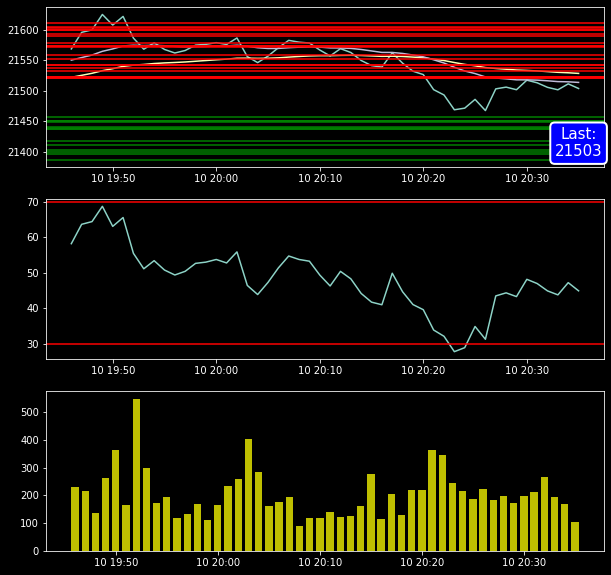

In [ ]:
fig, ax = plt.subplots(3, figsize = (10,10))
ax[0].plot(price_df.closeTime.tail(50),price_df.close.tail(50))
ax[0].plot(price_df.closeTime.tail(50),price_df.ma50.tail(50))
ax[0].plot(price_df.closeTime.tail(50),price_df.ma21.tail(50))
ax[0].text(price_df['closeTime'].tail(1), float(price_df['close'].mean())*0.995, f"Last:\n{int(price_df['close'].tail(1))}", ha="center", va="center", size=15, bbox=dict(boxstyle="round,pad=0.3", fc="blue", ec="w", lw=2))   
for i in sls:
  ax[0].axhline(y=i, color="r")
for i in bys:
  ax[0].axhline(y=i, color="g")
#ax[0].hlines(sls,xmin=float(asks.min()[0][0]), xmax = float(asks.max()[0][0]), color = "r")
#ax[0].hlines(bys,xmin=float(asks.min()[0][0]), xmax = float(asks.max()[0][0]), color = "g")
ax[1].plot(price_df.tail(50).closeTime,rsi.tail(50))
ax[1].axhline(y= 30, color = 'r')
ax[1].axhline(y= 70, color = 'r')

ax[2].bar(  price_df.closeTime.tail(50), price_df.volume.tail(50), width = 0.0005, color='y')


In [ ]:
 float (price_df.closeTime.tail(50).head(1).view(int)/10**9 ) 



1662839160.999